In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
#60 min level data

In [2]:
#數據準備
raw_data = pd.read_csv('okexFutureEth_all.csv')
len(raw_data['high'])

9985

In [3]:
_price = list(raw_data['close'])
_time = list(raw_data['date'])
_volume = list(raw_data['vol'])
price = _price[::-1]
volume = _volume[::-1]
time = _time[::-1]

In [4]:
price


[6731.26,
 6763.0,
 6751.74,
 6759.64,
 6740.0,
 6753.36,
 6685.49,
 6727.51,
 6752.87,
 6735.53,
 6751.36,
 6738.72,
 6746.6,
 6735.0,
 6755.0,
 6769.25,
 6777.06,
 6765.0,
 6730.18,
 6784.4,
 6790.76,
 6868.0,
 6885.9,
 6890.0,
 6883.69,
 6856.71,
 6855.54,
 6870.32,
 6848.8,
 6863.89,
 6879.32,
 6915.9,
 6874.09,
 6872.98,
 6905.68,
 6912.62,
 6919.94,
 6893.0,
 6800.02,
 6808.0,
 6825.0,
 6834.0,
 6952.02,
 7831.25,
 7805.0,
 7804.85,
 7803.0,
 7785.25,
 7769.86,
 7805.83,
 7806.67,
 7800.79,
 7835.1,
 7897.56,
 7950.0,
 7973.65,
 7970.22,
 7873.95,
 7936.87,
 7892.19,
 7896.78,
 7901.86,
 7924.0,
 8298.99,
 8215.71,
 8180.73,
 8154.91,
 8177.24,
 8296.46,
 8193.6,
 8198.84,
 8222.19,
 8211.44,
 8234.41,
 8234.37,
 8215.62,
 8045.45,
 8019.93,
 8076.06,
 8061.11,
 8088.92,
 8194.15,
 8196.35,
 8184.0,
 8095.3,
 8091.94,
 8144.91,
 8236.6,
 8202.44,
 8125.0,
 8037.45,
 8064.2,
 7966.17,
 8019.46,
 8037.98,
 7994.26,
 8017.83,
 8000.58,
 8048.75,
 8034.51,
 8093.17,
 8083.36,
 8084.6

In [5]:
#數據整理
#將原始數據整理裁減成需要的格式 待下一步計算和篩選
index = 23
temp = []
selected_data = []
unit_data = {}
highhour = 0
lowhour = 0
high = 0
low = 0
percent = 0
meanvol = 0
while index <= len(price):
    temp = price[index+1:index+24]
    high = max(temp)
    highhour = temp.index(high)
    low = min(temp)
    lowhour = temp.index(low)
    if highhour > lowhour:
        #上漲
        percent = (high-low)/temp[0]
    else:
        #下跌
        percent = (low-high)/temp[0]
    if abs(percent) >= 0.045:
        unit_data["percent"] = percent
        unit_data["fiveday_price"] = price[index+1:index+121]
        unit_data["price"] = price[index]
        unit_data["fiveday_volume"] = volume[index+1:index+121]
        if index == 23:
            meanvol = np.mean(volume[index-23:index])
        elif index == 47:
            meanvol = np.mean(volume[index-47:index])
        elif index == 71:
            meanvol = np.mean(volume[index-71:index])
        elif index == 95:
            meanvol = np.mean(volume[index-95:index])
        else:
            meanvol = np.mean(volume[index-119:index])
        unit_data["meanvol"] = meanvol
        unit_data["volume"] = volume[index]
        selected_data.append(unit_data)
        unit_data = {}
    index += 24

In [6]:
selected_data[105]

{'percent': -0.06466554249077436,
 'fiveday_price': [8782.73,
  8708.84,
  8758.57,
  8722.5,
  8565.19,
  8264.29,
  8324.16,
  8340.64,
  8361.86,
  8376.56,
  8337.94,
  8319.44,
  8214.79,
  8278.95,
  8331.98,
  8357.23,
  8320.53,
  8333.27,
  8338.73,
  8329.87,
  8379.8,
  8480.89,
  8483.84,
  8419.23,
  8450.79],
 'price': 9099.79,
 'fiveday_volume': [30883.56518959,
  17207.23268112,
  3506.27359019,
  3074.98285585,
  14423.10985033,
  27181.48963818,
  10265.00574569,
  5419.17531387,
  5464.104473699998,
  5750.11794919,
  4768.1615,
  7510.7352442,
  6034.88397512,
  6958.42245835,
  4166.44544231,
  3763.13165747,
  4539.98528513,
  2945.83126488,
  4565.11461226,
  4320.58470813,
  3398.85582452,
  11755.98623114,
  6191.91892087,
  5192.96751747,
  6734.63956518],
 'meanvol': 4537.668165056302,
 'volume': 9043.42029363}

In [7]:
#初步按照波動當天的波動方向將數據粗略分為兩部份
#分別是上漲波動 和下跌波動
positive_data = []
negative_data = []
for element in selected_data:
    if element["percent"] > 0:
        positive_data.append(element)
    else:
        negative_data.append(element)

In [8]:
#依照初步的上漲、下跌分類 粗略計算出波動後 回歸、繼續上漲 和下跌的百分比
#價格差別在0.5%內皆看作回歸
#百分比看作和波動當天比較
"""
po_bottom = len(positive_data)
ne_bottom = len(negative_data)
back = 0
up = 0
down = 0
for element in positive_data:
    if abs((element["fiveday_price"][-1]-element["price"])/element["price"]) <= 0.005:
        back += 1
    elif (element["fiveday_price"][-1]-element["price"])/element["price"] > 0.005:
        up += 1
    elif (element["fiveday_price"][-1]-element["price"])/element["price"] < (-0.005):
        down +=1
    
    print(back/po_bottom, up/po_bottom, down/po_bottom)
    print((back/po_bottom)+(up/po_bottom)+(down/po_bottom))
    print()
    
back = 0
up = 0
down = 0
print("##################################")

for element in negative_data:
    if abs((element["fiveday_price"][-1]-element["price"])/element["price"]) <= 0.005:
        back += 1
    elif (element["fiveday_price"][-1]-element["price"])/element["price"] > 0.005:
        up += 1
    elif (element["fiveday_price"][-1]-element["price"])/element["price"] < (-0.005):
        down +=1
    
    print(back/ne_bottom, up/ne_bottom, down/ne_bottom)
    print((back/ne_bottom)+(up/ne_bottom)+(down/ne_bottom))
    print()
"""

0.0 0.019230769230769232 0.0
0.019230769230769232

0.0 0.038461538461538464 0.0
0.038461538461538464

0.0 0.057692307692307696 0.0
0.057692307692307696

0.0 0.07692307692307693 0.0
0.07692307692307693

0.0 0.09615384615384616 0.0
0.09615384615384616

0.0 0.11538461538461539 0.0
0.11538461538461539

0.0 0.1346153846153846 0.0
0.1346153846153846

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.15384615384615385 0.019230769230769232
0.17307692307692307

0.0 0.17307692307692307 0.019230769230769232
0.1923076923076923

0.0 0.19230769230769232 0.019230769230769232
0.21153846153846156

0.0 0.21153846153846154 0.019230769230769232
0.23076923076923078

0.0 0.23076923076923078 0.019230769230769232
0.25

0.0 0.25 0.019230769230769232
0.2692307692307692

0.0 0.2692307692307692 0.019230769230769232
0.28846153846153844

0.0 0.28846153846153844 0.019230769230769232
0.30769230769230765

0.0 0.3076923076923077 0.019230769230769232
0.3269230769230769

0.0 0.3269230769230769 0.0192

In [9]:
element["fiveday_price"][-1]

8450.79

In [11]:
po_bottom = len(positive_data)
ne_bottom = len(negative_data)
back = 0
up = 0
down = 0
for element in positive_data:
    if element["volume"]<element["meanvol"]:
        if abs((element["fiveday_price"][-1]-element["price"])/element["price"]) <= 0.005:
            back += 1
        elif (element["fiveday_price"][-1]-element["price"])/element["price"] > 0.005:
            up += 1
        elif (element["fiveday_price"][-1]-element["price"])/element["price"] < (-0.005):
            down +=1
    
    print(back/po_bottom, up/po_bottom, down/po_bottom)
    print((back/po_bottom)+(up/po_bottom)+(down/po_bottom))
    print()
    
back = 0
up = 0
down = 0
print("##################################")

for element in negative_data:
    if element["volume"]<element["meanvol"]:
        if abs((element["fiveday_price"][-1]-element["price"])/element["price"]) <= 0.005:
            back += 1
        elif (element["fiveday_price"][-1]-element["price"])/element["price"] > 0.005:
            up += 1
        elif (element["fiveday_price"][-1]-element["price"])/element["price"] < (-0.005):
            down +=1
    
    print(back/ne_bottom, up/ne_bottom, down/ne_bottom)
    print((back/ne_bottom)+(up/ne_bottom)+(down/ne_bottom))
    print()

0.0 0.0 0.0
0.0

0.0 0.019230769230769232 0.0
0.019230769230769232

0.0 0.038461538461538464 0.0
0.038461538461538464

0.0 0.057692307692307696 0.0
0.057692307692307696

0.0 0.057692307692307696 0.0
0.057692307692307696

0.0 0.07692307692307693 0.0
0.07692307692307693

0.0 0.09615384615384616 0.0
0.09615384615384616

0.0 0.09615384615384616 0.019230769230769232
0.11538461538461539

0.0 0.11538461538461539 0.019230769230769232
0.13461538461538464

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.1346153846153846 0.019230769230769232
0.15384615384615385

0.0 0.15384615384615385 0.019230769230769232
0.17307692307692307

0.0 0.15384615384615385 0.019230769230769232
0.17307692307692307

0.0 0.17307692307692307 0.0

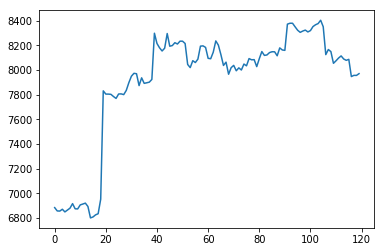

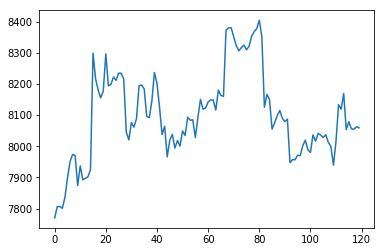

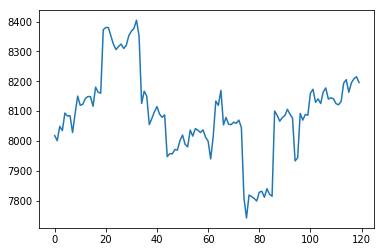

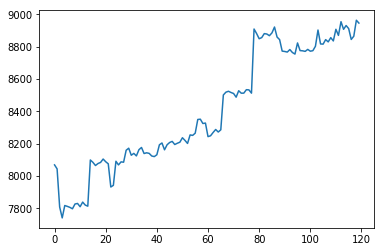

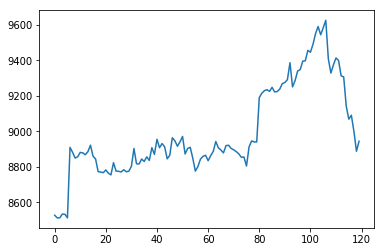

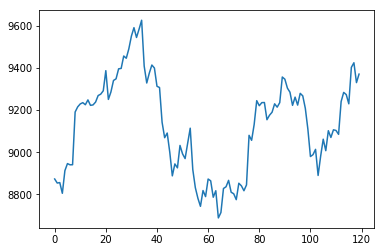

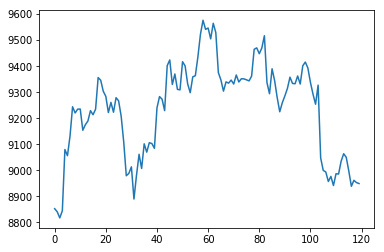

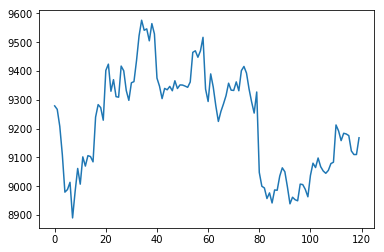

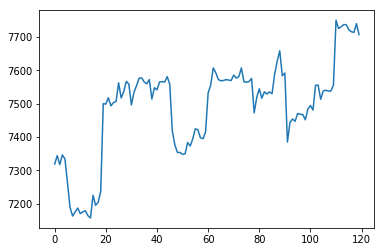

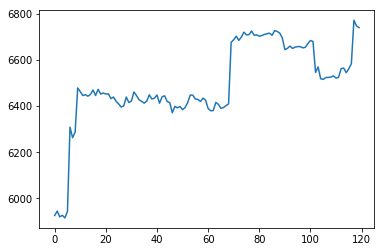

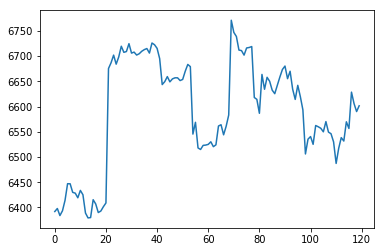

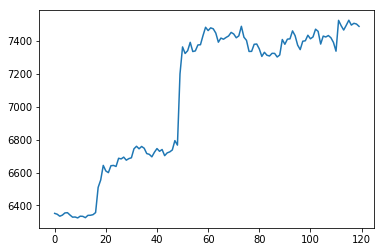

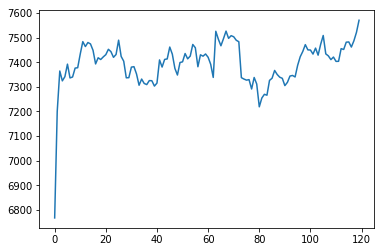

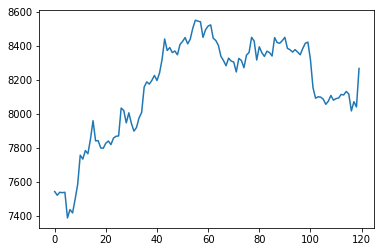

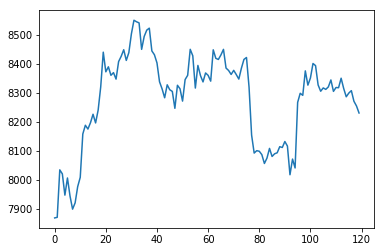

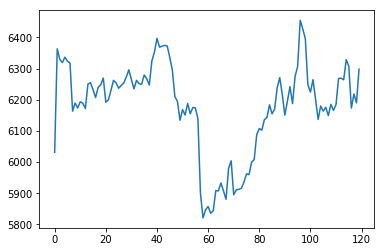

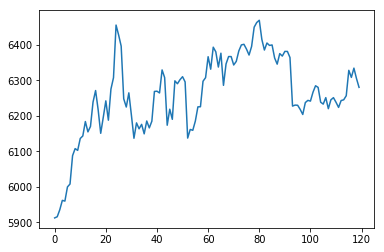

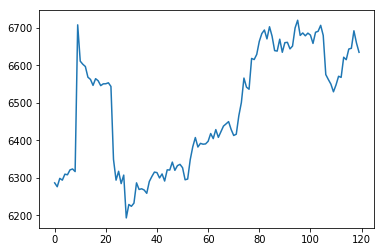

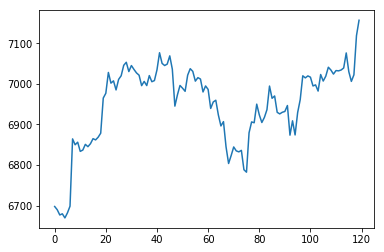

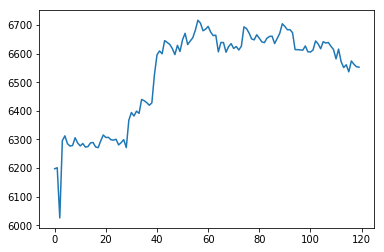

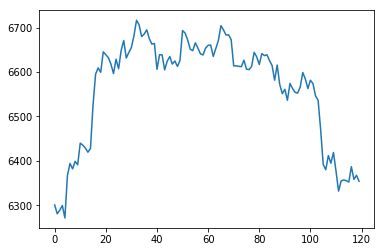

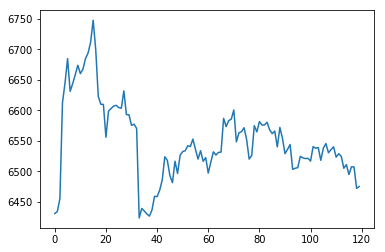

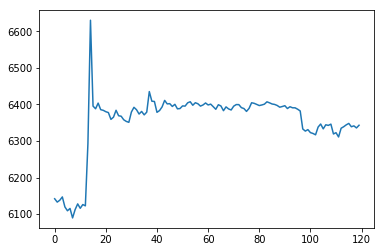

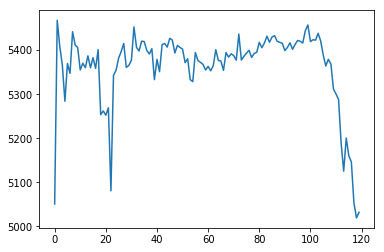

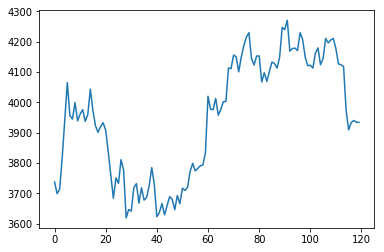

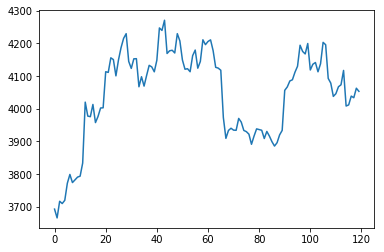

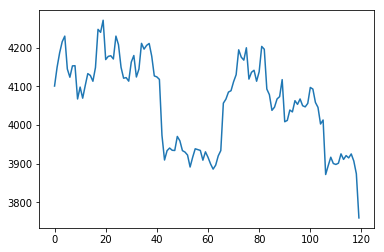

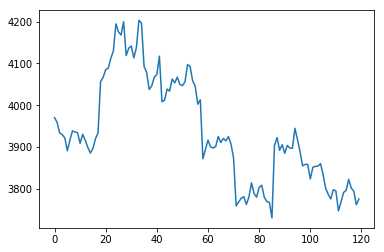

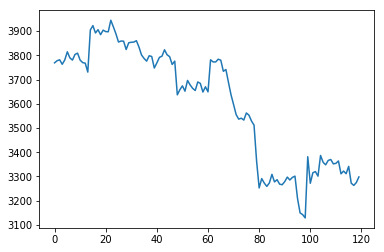

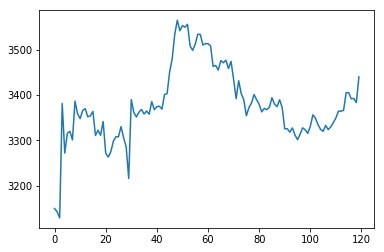

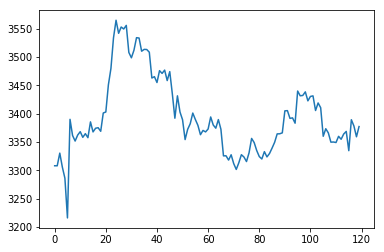

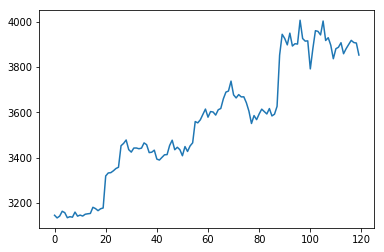

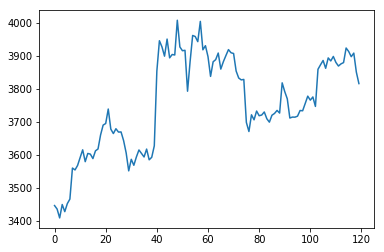

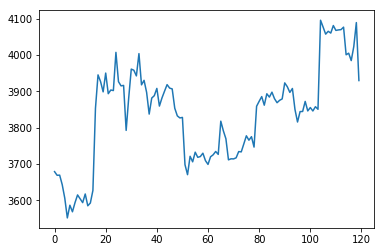

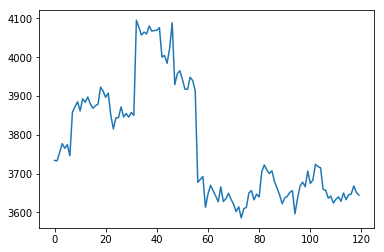

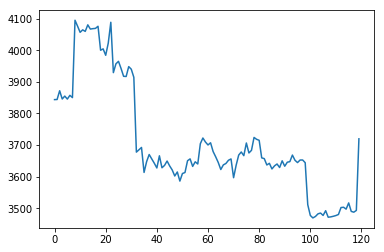

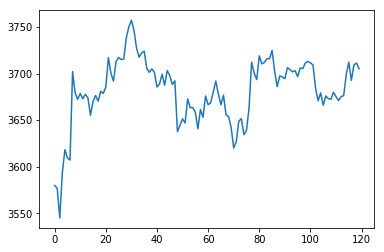

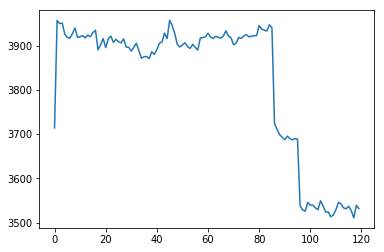

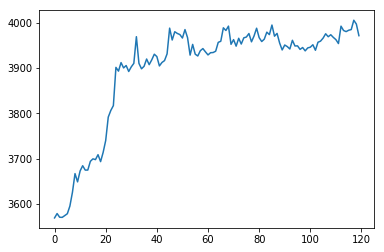

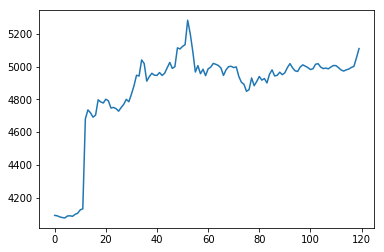

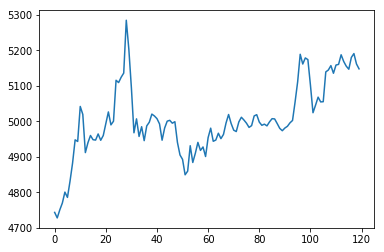

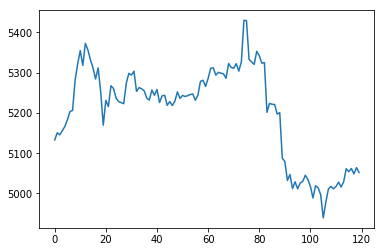

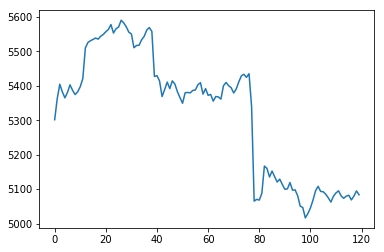

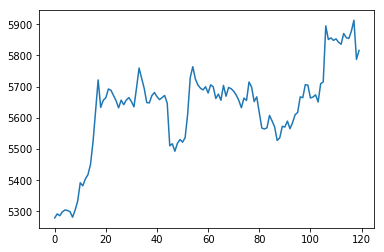

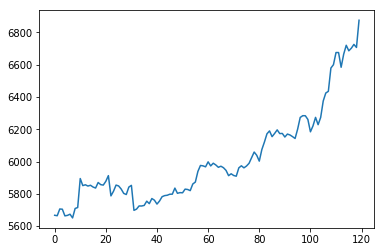

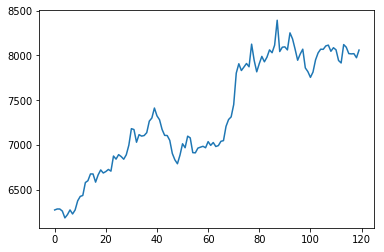

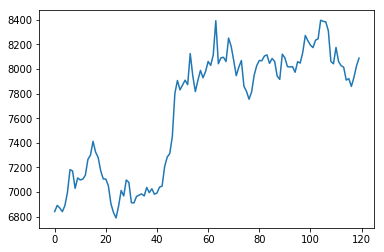

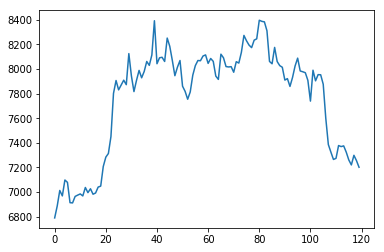

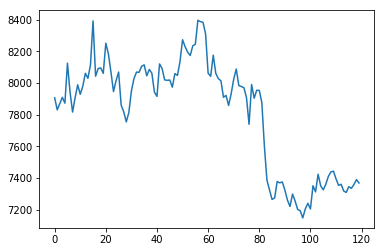

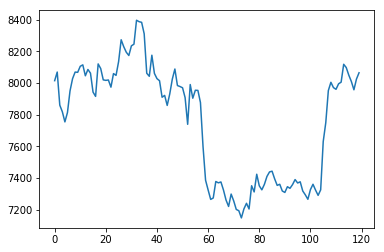

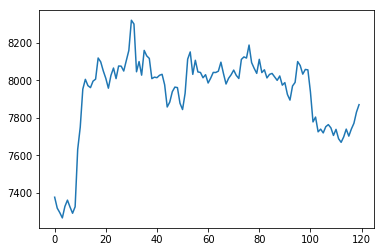

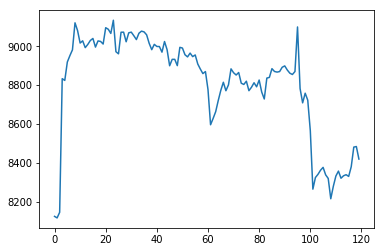

************************************************


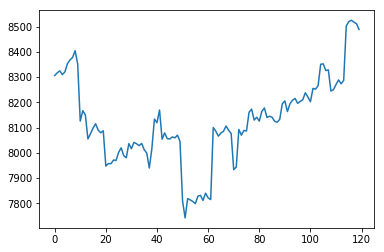

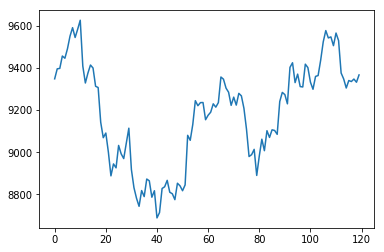

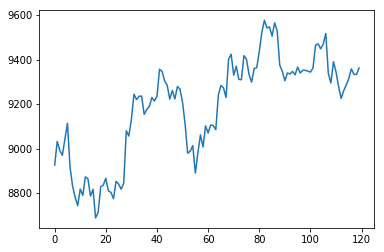

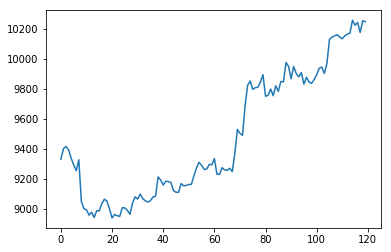

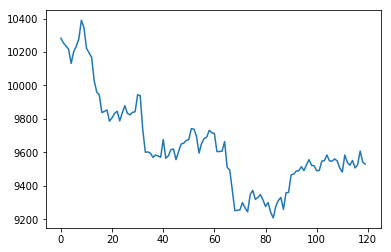

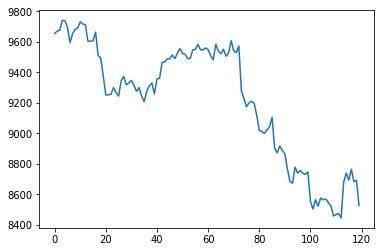

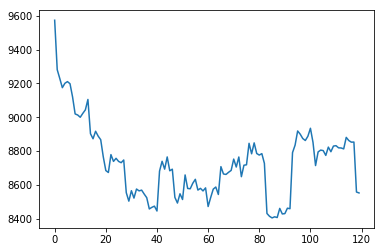

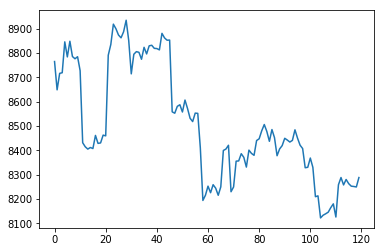

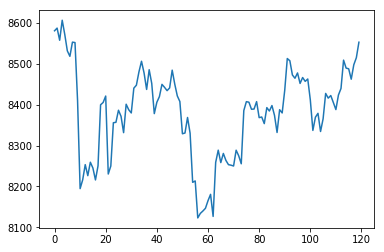

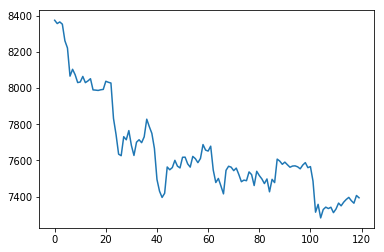

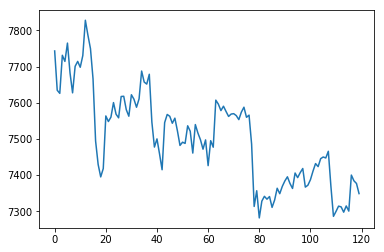

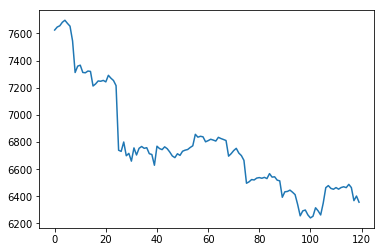

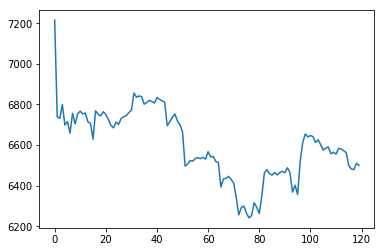

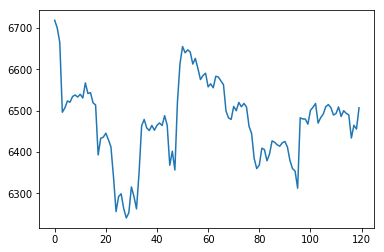

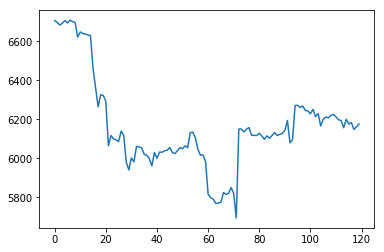

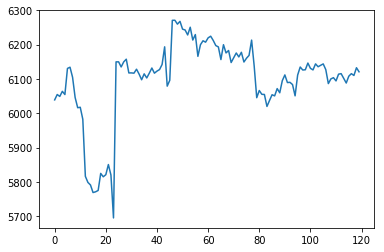

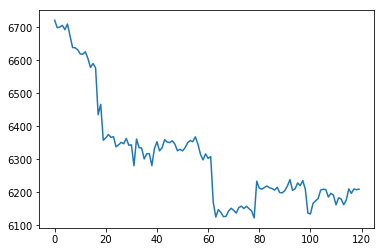

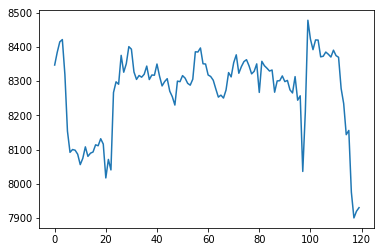

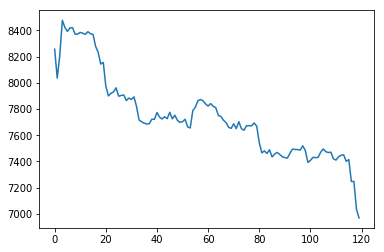

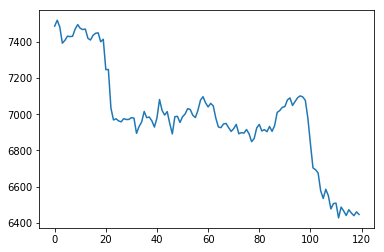

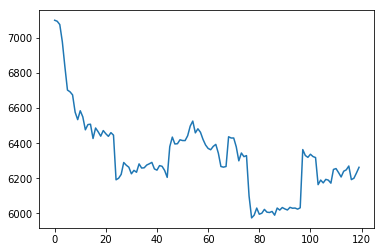

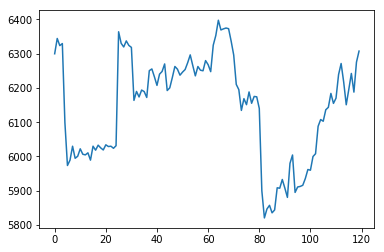

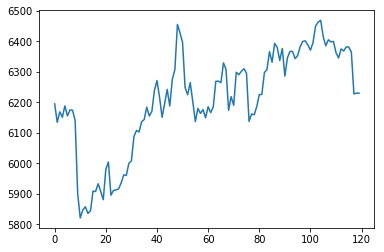

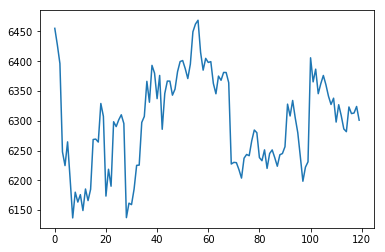

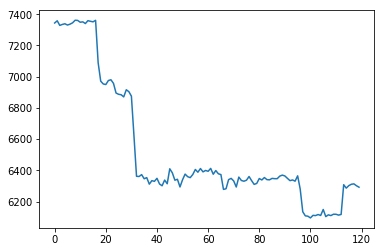

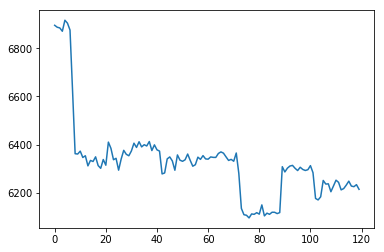

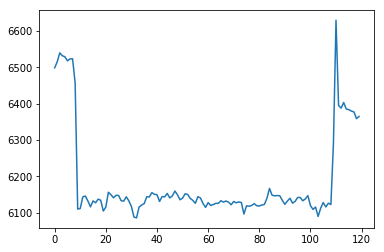

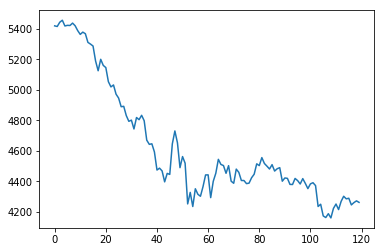

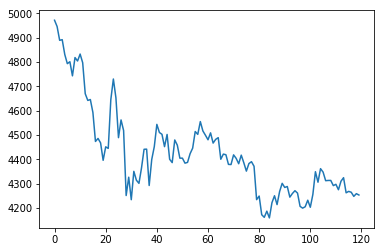

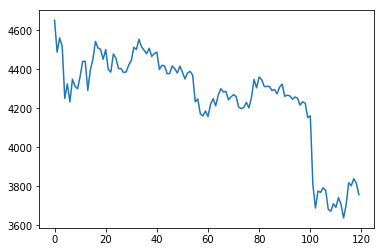

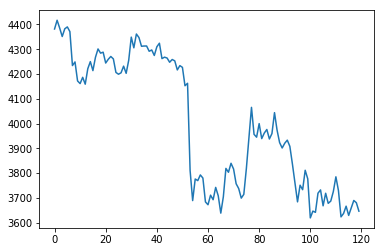

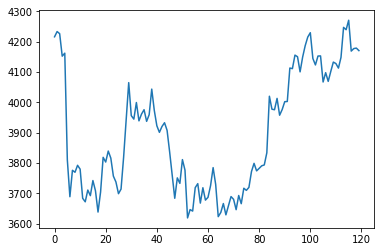

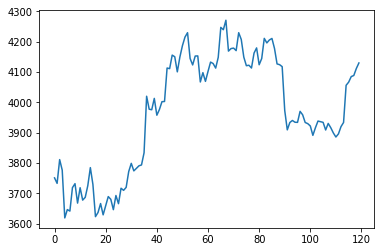

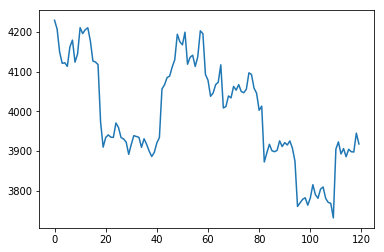

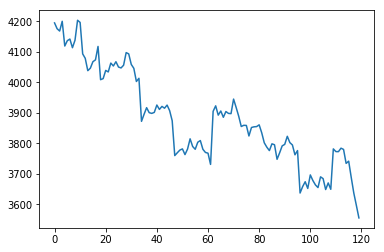

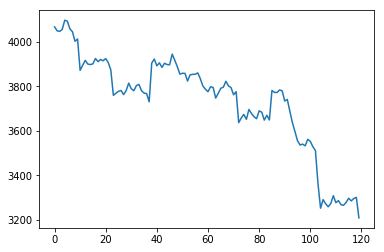

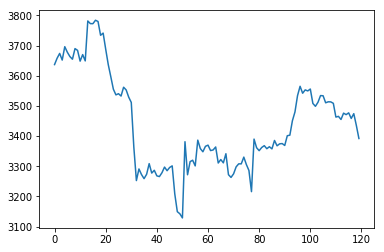

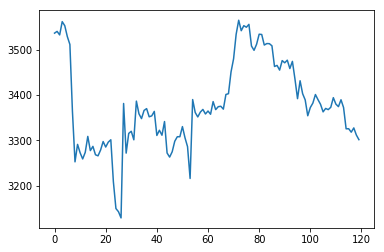

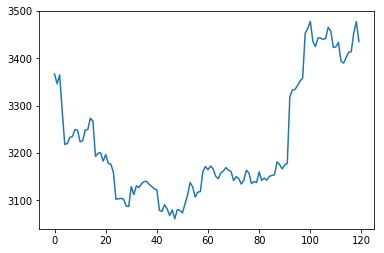

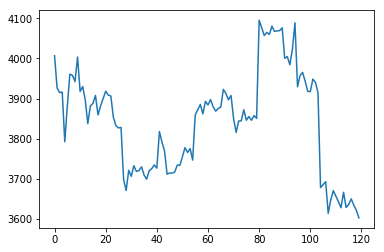

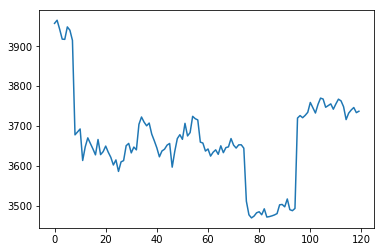

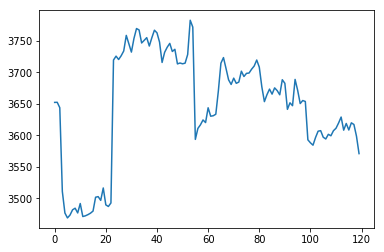

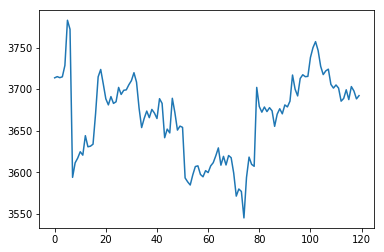

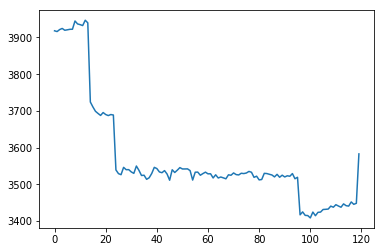

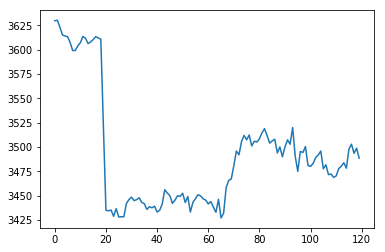

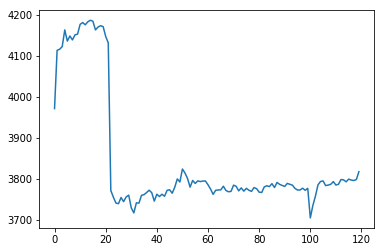

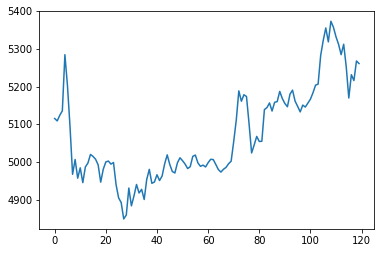

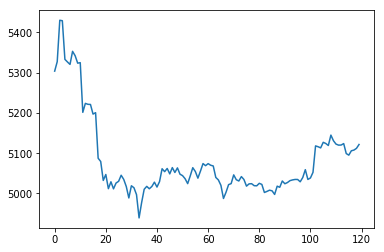

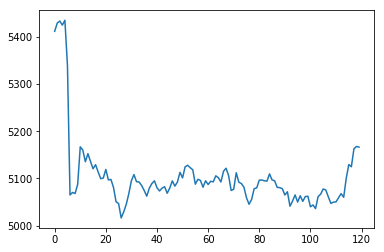

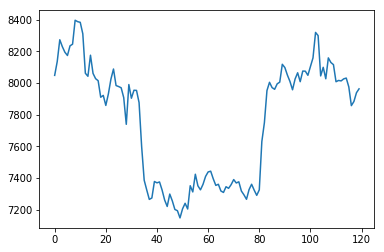

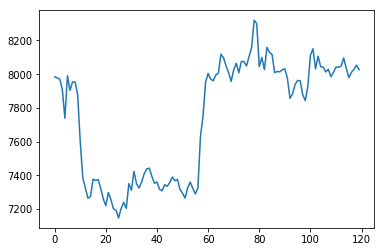

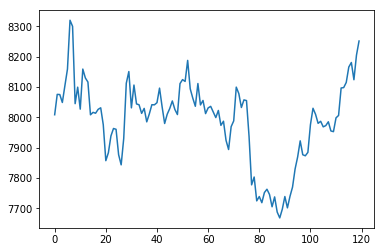

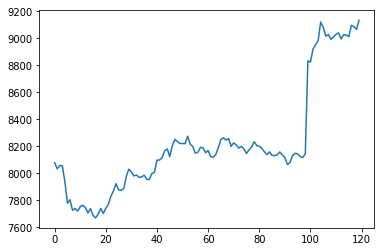

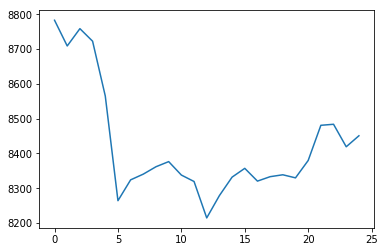

In [20]:
#畫圖 通過觀察未來五天內的價格和交易量來找規律
for page in positive_data:
    plt.plot(page["fiveday_price"])
    #plt.plot(page["fiveday_volume"])
    plt.show()
print("************************************************")
for page in negative_data:
    plt.plot(page["fiveday_price"])
    #plt.plot(page["fiveday_volume"])
    plt.show()

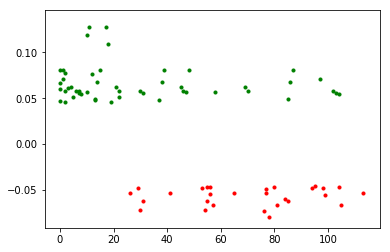

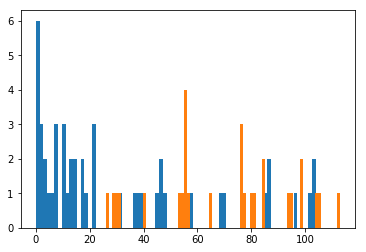

49 28


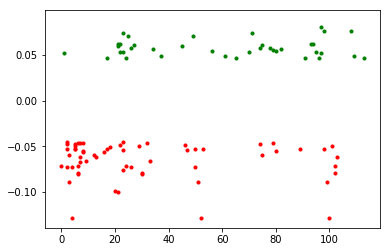

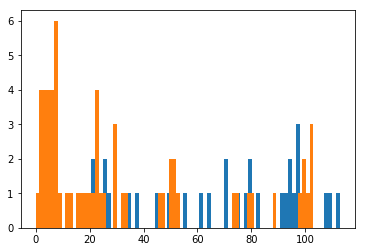

38 61


In [47]:
#尋找未來五天的規律 看3小時波動率 找到超過4.5%的點 然後做圖分析
#針對當日上漲波動 其基礎上上航波動大於等於4.5%
po_po = []
po_ne = []
po_hr = []
ne_hr = []

for afterpo in positive_data:
    for hour in range(117):
        if len(afterpo["fiveday_price"]) < 119:
            break
        p = (afterpo["fiveday_price"][hour+2]-afterpo["fiveday_price"][hour])/afterpo["fiveday_price"][hour+2]
        if p >= 0.045:
            po_po.append(p)
            po_hr.append(hour)
        elif p <= -0.045:
            po_ne.append(p)
            ne_hr.append(hour)
        #print(hour)

plt.scatter(po_hr,po_po,np.pi*3,"green")
plt.scatter(ne_hr,po_ne,np.pi*3,"red")
plt.show()
plt.hist(po_hr, bins=75)
plt.hist(ne_hr, bins=75)
plt.show()
print(len(po_po),len(po_ne))


ne_po = []
ne_ne = []
po_hr = []
ne_hr = []
for afterpo in negative_data:
    for hour in range(117):
        if len(afterpo["fiveday_price"]) < 119:
            break
        p = (afterpo["fiveday_price"][hour+2]-afterpo["fiveday_price"][hour])/afterpo["fiveday_price"][hour+2]
        if p >= 0.045:
            ne_po.append(p)
            po_hr.append(hour)
        elif p <= -0.045:
            ne_ne.append(p)
            ne_hr.append(hour)
        #print(hour)

plt.scatter(po_hr,ne_po,np.pi*3,"green")
plt.scatter(ne_hr,ne_ne,np.pi*3,"red")
plt.show()
plt.hist(po_hr, bins=75)
plt.hist(ne_hr, bins=75)
plt.show()
print(len(ne_po),len(ne_ne))